# Content

- [Aims](#Aims)
- [Helper Functions](#Helper-Functions)
- [Data Description](#Data-Description)
- [Import Data](#Import-Data)
- [Data Preprocessing](#Data-Preprocessing)
- [Data Splitting](#Data-Splitting)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
- [Further Work](#Further-Work)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_ks_statistic

import warnings
warnings.filterwarnings('ignore')

# Aims

- To find out what factors are significant to the win rate.
- To analyze how the significant factors affect the win rate.

# Helper Functions

In [2]:
def forward_selection(X, y, alpha = 0.05):
    logit = sm.GLM(y, np.ones(len(X)), family = sm.families.Binomial()).fit()
    prev_deviance = logit.deviance
        
    selected_list = []
    remaining_list = X.columns.tolist().copy()
    selected = None
    p_value = None
    for i in range(X.shape[1]):
        deviance_min = np.inf
        for col in remaining_list:
            cols = selected_list.copy()
            cols.append(col)
            logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
            if deviance_min > logit.deviance:
                deviance_min = logit.deviance
                selected = col
        
        test_statistic = prev_deviance - deviance_min
        p_value = stats.chi2.sf(test_statistic, df = 1)

        if p_value < alpha:
            selected_list.append(selected)
            remaining_list.remove(selected)
            prev_deviance = deviance_min
                
        else:
            return selected_list

In [3]:
def backward_elimination(X, y, alpha = 0.10):
    logit = sm.GLM(y, sm.add_constant(X), family = sm.families.Binomial()).fit()
    prev_deviance = logit.deviance
        
    remaining_list = X.columns.tolist().copy()
    removed = None
    p_value = None
    for i in range(X.shape[1]):
        deviance_min = np.inf
        for col in remaining_list:
            cols = remaining_list.copy()
            cols.remove(col)
            logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
            if deviance_min > logit.deviance:
                deviance_min = logit.deviance
                removed = col
            
        test_statistic = deviance_min - prev_deviance
        p_value = stats.chi2.sf(test_statistic, df = 1)

        if p_value >= alpha:
            remaining_list.remove(removed)
            prev_deviance = deviance_min
                
        else:
            return remaining_list

In [4]:
def stepwise_regression(X, y, alpha_in = 0.05, alpha_out = 0.10):
    logit = sm.GLM(y, np.ones(len(X)), family = sm.families.Binomial()).fit()
    prev_deviance = logit.deviance
        
    remaining_list = X.columns.tolist().copy()
    selected_list = []
    selected = None
    removed = None
    p_value_in = None
    p_value_out = None
      
    while len(remaining_list) != 0:
        deviance_min = np.inf
        for col in remaining_list:
            cols = selected_list.copy()
            cols.append(col)
            
            logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
            
            if deviance_min > logit.deviance:
                selected = col
                deviance_min = logit.deviance
                
        test_statistic = prev_deviance - deviance_min
        p_value = stats.chi2.sf(test_statistic, df = 1)
        
        
        if p_value < alpha_in:
            selected_list.append(selected)
            remaining_list.remove(selected)
            prev_deviance = deviance_min
                
        else:
            return selected_list
        
        deviance_min = np.inf
        for col in selected_list:
            cols = selected_list.copy()
            cols.remove(col)
            
            if len(cols) == 0:
                logit = sm.GLM(y, np.ones(len(X)), family = sm.families.Binomial()).fit()
            else:
                logit = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Binomial()).fit()
                
            if deviance_min > logit.deviance:
                removed = col
                deviance_min = logit.deviance
        
        test_statistic = deviance_min - prev_deviance
        p_value = stats.chi2.sf(test_statistic, df = 1)        
        
        if p_value >= alpha_out:
            selected_list.remove(removed)
            remaining_list.append(removed)
            prev_deviance = deviance_min

# Data Description

The data is crawled on 12-02-2021. The data is the match history of 5,014 unrank Summoner's Rift matches in NA server from 05-02-2021 to 12-02-2021.

- Side: The side of the team (Blue / Red)
- Win: Whether the team won (1: Yes/ 0: No)
- First_Blood: Whether the team got the first blood (1: Yes/ 0: No)
- First_Tower: Whether the team got the first tower (1: Yes/ 0: No)
- First_Inhibitor: Whether the team got the first inhibitor (1: Yes/ 0: No)
- First_Baron: Whether the team got the first Baron (1: Yes/ 0: No)
- First_Dragon: Whether the team got the first Dragon (1: Yes/ 0: No)
- First_Rift_Herald: Whether the team got the first Rift Herald (1: Yes/ 0: No)
- Tower_Destroyed: Number of towers the team destroyed
- Inhibitor_Destroyed: Number of inhibitors the team destroyed
- Baron_Killed: Number of Baron the team killed
- Dragon_Killed: Number of Dragon the team killed
- Vilemaw_Killed: Number of Vilemaw the team killed
- Rift_Herald_Killed: Number of Vilemaw the team killed
- Game_Duration: Game Duration (in second)
- Total_Kills: Number of kills of the team
- Total_Deaths: Number of deaths of the team
- Total_Assists: Number of assists of the team
- Total_Magic_Damage_Dealt: Total amount of magic damage the team dealt
- Total_Physical_Damage_Dealt: Total amount of physical damage the team dealt
- Total_True_Damage_Dealt: Total amount of true damage the team dealt
- Total_Magic_Damage_To_Champions: Total amount of magic damage the team dealt to opposite champions
- Total_Physical_Damage_To_Champions: Total amount of physical damage the team dealt to opposite champions
- Total_True_Damage_To_Champions: Total amount of true damage the team dealt to opposite champions
- Total_Heal: Total amount of HP the team healed
- Total_Damage_Self_Mitigated: Total amount of damage self mitigated of the team
- Total_Damage_Dealt_To_Objectives: Total amount of damage the team dealt to objectives
- Total_Damage_Dealt_To_Turrets: Total amount of damage the team dealt to turrets
- Total_Vision_Score: Total vision score
- Total_Time_CCing_Others: Total time of the team crowd-controling (CCing) opposite team (in second)
- Total_Magical_Damage_Taken: Total amount of magic damage the team took
- Total_Physical_Damage_Taken: Total amount of physical damage the team took
- Total_True_Damage_Taken: Total amount of true damage the team took
- Total_Gold_Earned: Total amount of gold the team earned
- Total_Minions_Killed: Total number of minions the team killed
- Total_Neutral_Minions_Killed: Total number of neutral minions the team killed
- Total_Neutral_Minions_Killed_Team_Jungle: Total number of neutral minions in the team's jungle the team killed
- Total_Neutral_Minions_Killed_Enemy_Jungle: Total number of neutral minions in the enemy's jungle the team killed
- Total_Time_Crowd_Control_Dealt: Total time of crowd-control the team dealt (in second)
- Total_Champion_Level: The sum of the levels of the champions in the team.

# Import Data

In [5]:
data = pd.read_csv('../../data/LOL/lol_matches.csv')
data.shape

(10028, 40)

In [6]:
data.head()

,Side,Win,First_Blood,First_Tower,First_Inhibitor,First_Baron,First_Dragon,First_Rift_Herald,Tower_Destroyed,Inhibitor_Destroyed,...,Total_Magical_Damage_Taken,Total_Physical_Damage_Taken,Total_True_Damage_Taken,Total_Gold_Earned,Total_Minions_Killed,Total_Neutral_Minions_Killed,Total_Neutral_Minions_Killed_Team_Jungle,Total_Neutral_Minions_Killed_Enemy_Jungle,Total_Time_Crowd_Control_Dealt,Total_Champion_Level
0,Blue,1,1,1,0,0,1,0,3,0,...,17957,24170,2918,33464,371,112,44,48,409,52
1,Red,0,0,0,0,0,0,0,0,0,...,11373,24629,3072,22981,234,0,0,0,312,43
2,Blue,1,1,0,1,1,0,0,10,2,...,47291,91322,14940,72312,745,205,149,16,850,84
3,Red,0,0,1,0,0,1,1,10,2,...,30115,105230,18267,71655,709,194,103,40,1617,73
4,Blue,1,1,0,0,1,0,0,5,0,...,19756,47415,4319,47929,560,137,93,4,636,68


# Data Preprocessing

In [7]:
data['Blue'] = [1 if x == 'Blue' else 0 for x in data['Side']]
data = data.drop('Side', axis = 1)
data.head()

,Win,First_Blood,First_Tower,First_Inhibitor,First_Baron,First_Dragon,First_Rift_Herald,Tower_Destroyed,Inhibitor_Destroyed,Baron_Killed,...,Total_Physical_Damage_Taken,Total_True_Damage_Taken,Total_Gold_Earned,Total_Minions_Killed,Total_Neutral_Minions_Killed,Total_Neutral_Minions_Killed_Team_Jungle,Total_Neutral_Minions_Killed_Enemy_Jungle,Total_Time_Crowd_Control_Dealt,Total_Champion_Level,Blue
0,1,1,1,0,0,1,0,3,0,0,...,24170,2918,33464,371,112,44,48,409,52,1
1,0,0,0,0,0,0,0,0,0,0,...,24629,3072,22981,234,0,0,0,312,43,0
2,1,1,0,1,1,0,0,10,2,1,...,91322,14940,72312,745,205,149,16,850,84,1
3,0,0,1,0,0,1,1,10,2,0,...,105230,18267,71655,709,194,103,40,1617,73,0
4,1,1,0,0,1,0,0,5,0,1,...,47415,4319,47929,560,137,93,4,636,68,1


In [8]:
data['Vilemaw_Killed'].value_counts()
# In the sample, none of the teams killed Vilemaw.

0    10028
Name: Vilemaw_Killed, dtype: int64

In [9]:
data = data.drop('Vilemaw_Killed', axis = 1)
data.head()

,Win,First_Blood,First_Tower,First_Inhibitor,First_Baron,First_Dragon,First_Rift_Herald,Tower_Destroyed,Inhibitor_Destroyed,Baron_Killed,...,Total_Physical_Damage_Taken,Total_True_Damage_Taken,Total_Gold_Earned,Total_Minions_Killed,Total_Neutral_Minions_Killed,Total_Neutral_Minions_Killed_Team_Jungle,Total_Neutral_Minions_Killed_Enemy_Jungle,Total_Time_Crowd_Control_Dealt,Total_Champion_Level,Blue
0,1,1,1,0,0,1,0,3,0,0,...,24170,2918,33464,371,112,44,48,409,52,1
1,0,0,0,0,0,0,0,0,0,0,...,24629,3072,22981,234,0,0,0,312,43,0
2,1,1,0,1,1,0,0,10,2,1,...,91322,14940,72312,745,205,149,16,850,84,1
3,0,0,1,0,0,1,1,10,2,0,...,105230,18267,71655,709,194,103,40,1617,73,0
4,1,1,0,0,1,0,0,5,0,1,...,47415,4319,47929,560,137,93,4,636,68,1


# Data Splitting

In [10]:
train, test = train_test_split(data, test_size = 0.2, random_state = 0)
train.shape, test.shape

((8022, 39), (2006, 39))

In [11]:
train, validate = train_test_split(train, test_size = 0.1, random_state = 0)
train.shape, validate.shape

((7219, 39), (803, 39))

# Models

## Full Model

In [12]:
X = train.drop('Win', axis = 1)
y = train['Win']

In [13]:
full_model = sm.GLM(y, sm.add_constant(X), family = sm.families.Binomial()).fit()
full_model.summary()
# First_Blood, First_Inhibitor, First_Baron

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7180
Model Family:                Binomial   Df Model:                           38
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -826.19
Date:                Thu, 25 Feb 2021   Deviance:                       1652.4
Time:                        03:26:19   Pearson chi2:                 2.48e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -1.4060      0.283     -4.973      0.000      -1.960      -0.852
First_Blood                                  -0.0594      0.133     -0.446      0.656      -0.320       0.202
First_Tower                                   0.4523      0.151      2.998      0.003       0.157       0.748
First_Inhibitor                              -0.1801      0.219     -0.821      0.412      -0.610       0.250
First_Baron                                  -0.6821      0.303     -2.253      0.024      -1.275      -0.089
First_Dragon                                 -0.3018      0.166     -1.816      0.069      -0.627       0.024
First_Rift_Herald                             0.4940      0.330      1.499      0.134      -0.152       1.140
Tower_Destroyed                               0.6219      0.081      7.642      0.000       0.462       0.781
Inhibitor_Destroyed                           0.7686      0.115      6.657      0.000       0.542       0.995
Baron_Killed                                  0.8681      0.303      2.861      0.004       0.273       1.463
Dragon_Killed                                 0.4180      0.113      3.706      0.000       0.197       0.639
Rift_Herald_Killed                           -0.4164      0.300     -1.387      0.165      -1.005       0.172
Game_Duration                                -0.0102      0.001    -12.515      0.000      -0.012      -0.009
Total_Kills                                  -0.0287      0.021     -1.364      0.172      -0.070       0.013
Total_Deaths                                 -0.2478      0.016    -15.836      0.000      -0.278      -0.217
Total_Assists                                 0.0061      0.008      0.786      0.432      -0.009       0.021
Total_Magic_Damage_Dealt                   2.696e-06   2.21e-06      1.217      0.223   -1.64e-06    7.04e-06
Total_Physical_Damage_Dealt                 3.55e-06   1.97e-06      1.806      0.071   -3.02e-07     7.4e-06
Total_True_Damage_Dealt                    -9.48e-07   2.37e-06     -0.399      0.690    -5.6e-06     3.7e-06
Total_Magic_Damage_To_Champions            3.551e-05   8.71e-06      4.078      0.000    1.84e-05    5.26e-05
Total_Physical_Damage_To_Champions         1.383e-05   8.44e-06      1.638      0.101   -2.72e-06    3.04e-05
Total_True_Damage_To_Champions             4.329e-05   1.92e-05      2.260      0.024    5.75e-06    8.08e-05
Total_Heal                                 2.861e-05      9e-06      3.180      0.001     1.1e-05    4.62e-05
Total_Damage_Self_Mitigated                3.844e-06   3.59e-06      1.071      0.284   -3.19e-06    1.09e-05
Total_Damage_Dealt_To_Objectives          -8.569e-06   1.17e-05     -0.734      0.463   -3.14e-05    1.43e-05
Tot

In [14]:
critical_value = stats.chi2.ppf(0.95, df=full_model.df_resid)
p_value = stats.chi2.sf(full_model.deviance, df=full_model.df_resid)

print('Test statistic:', full_model.deviance)
print('Critical value:', critical_value)
print('p-value:', p_value)
# The lack of fit problem is not significant.

Test statistic: 1652.3840015604662
Critical value: 7378.238564677696
p-value: 1.0


## Forward Selection

In [15]:
forward_features = forward_selection(X, y)
forward_features

['Tower_Destroyed',
 'Total_Deaths',
 'Total_Kills',
 'Game_Duration',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Champion_Level',
 'Inhibitor_Destroyed',
 'Total_Neutral_Minions_Killed',
 'Dragon_Killed',
 'Total_Magic_Damage_To_Champions',
 'Total_Time_CCing_Others',
 'Total_Vision_Score',
 'Total_Physical_Damage_To_Champions',
 'Total_Physical_Damage_Taken',
 'Total_Magical_Damage_Taken',
 'Total_Heal',
 'First_Tower',
 'Baron_Killed',
 'First_Baron']

In [16]:
forward_model = sm.GLM(y, sm.add_constant(X[forward_features]), family = sm.families.Binomial()).fit()
forward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7198
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -838.59
Date:                Thu, 25 Feb 2021   Deviance:                       1677.2
Time:                        03:28:01   Pearson chi2:                 3.27e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.3956      0.260     -5.373      0.000      -1.905      -0.887
Tower_Destroyed                        0.4960      0.052      9.611      0.000       0.395       0.597
Total_Deaths                          -0.2593      0.014    -18.547      0.000      -0.287      -0.232
Total_Kills                           -0.0418      0.020     -2.104      0.035      -0.081      -0.003
Game_Duration                         -0.0100      0.001    -13.507      0.000      -0.012      -0.009
Total_Gold_Earned                      0.0004   4.51e-05      9.944      0.000       0.000       0.001
Total_Minions_Killed                  -0.0126      0.002     -7.714      0.000      -0.016      -0.009
Total_Champion_Level                   0.1664      0.018      9.400      0.000       0.132       0.201
Inhibitor_Destroyed                    0.7248      0.101      7.205      0.000       0.528       0.922
Total_Neutral_Minions_Killed          -0.0135      0.002     -5.813      0.000      -0.018      -0.009
Dragon_Killed                          0.3605      0.071      5.102      0.000       0.222       0.499
Total_Magic_Damage_To_Champions     4.019e-05   5.88e-06      6.833      0.000    2.87e-05    5.17e-05
Total_Time_CCing_Others               -0.0064      0.002     -3.891      0.000      -0.010      -0.003
Total_Vision_Score                    -0.0109      0.003     -3.925      0.000      -0.016      -0.005
Total_Physical_Damage_To_Champions  2.226e-05   6.52e-06      3.414      0.001    9.48e-06     3.5e-05
Total_Physical_Damage_Taken        -3.758e-05   6.77e-06     -5.554      0.000   -5.08e-05   -2.43e-05
Total_Magical_Damage_Taken         -3.392e-05   6.57e-06     -5.159      0.000   -4.68e-05    -2.1e-05
Total_Heal                          2.343e-05    8.1e-06      2.892      0.004    7.55e-06    3.93e-05
First_Tower                            0.3622      0.142      2.546      0.011       0.083       0.641
Baron_Killed                           0.8177      0.244      3.348      0.001       0.339       1.296
First_Baron                           -0.7228      0.292     -2.474      0.013      -1.295      -0.150
======================================================================================================
"""

## Backward Elimination

In [17]:
backward_features = backward_elimination(X, y)
backward_features

['First_Tower',
 'First_Baron',
 'First_Dragon',
 'Tower_Destroyed',
 'Inhibitor_Destroyed',
 'Baron_Killed',
 'Dragon_Killed',
 'Game_Duration',
 'Total_Kills',
 'Total_Deaths',
 'Total_Magic_Damage_To_Champions',
 'Total_Physical_Damage_To_Champions',
 'Total_True_Damage_To_Champions',
 'Total_Heal',
 'Total_Vision_Score',
 'Total_Time_CCing_Others',
 'Total_Magical_Damage_Taken',
 'Total_Physical_Damage_Taken',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Neutral_Minions_Killed_Team_Jungle',
 'Total_Neutral_Minions_Killed_Enemy_Jungle',
 'Total_Champion_Level']

In [18]:
backward_model = sm.GLM(y, sm.add_constant(X[backward_features]), family = sm.families.Binomial()).fit()
backward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7195
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -834.06
Date:                Thu, 25 Feb 2021   Deviance:                       1668.1
Time:                        03:31:21   Pearson chi2:                 2.94e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -1.3847      0.260     -5.327      0.000      -1.894      -0.875
First_Tower                                   0.3778      0.144      2.624      0.009       0.096       0.660
First_Baron                                  -0.6577      0.295     -2.232      0.026      -1.235      -0.080
First_Dragon                                 -0.3064      0.162     -1.893      0.058      -0.624       0.011
Tower_Destroyed                               0.5044      0.053      9.495      0.000       0.400       0.609
Inhibitor_Destroyed                           0.7280      0.102      7.166      0.000       0.529       0.927
Baron_Killed                                  0.7449      0.246      3.028      0.002       0.263       1.227
Dragon_Killed                                 0.3756      0.080      4.708      0.000       0.219       0.532
Game_Duration                                -0.0101      0.001    -13.547      0.000      -0.012      -0.009
Total_Kills                                  -0.0385      0.020     -1.910      0.056      -0.078       0.001
Total_Deaths                                 -0.2616      0.014    -18.582      0.000      -0.289      -0.234
Total_Magic_Damage_To_Champions            4.081e-05   5.98e-06      6.825      0.000    2.91e-05    5.25e-05
Total_Physical_Damage_To_Champions         2.266e-05   6.62e-06      3.425      0.001    9.69e-06    3.56e-05
Total_True_Damage_To_Champions             3.187e-05    1.8e-05      1.774      0.076   -3.34e-06    6.71e-05
Total_Heal                                 2.213e-05   8.15e-06      2.714      0.007    6.15e-06    3.81e-05
Total_Vision_Score                           -0.0120      0.003     -4.299      0.000      -0.017      -0.007
Total_Time_CCing_Others                      -0.0064      0.002     -3.838      0.000      -0.010      -0.003
Total_Magical_Damage_Taken                 -3.27e-05   6.62e-06     -4.942      0.000   -4.57e-05   -1.97e-05
Total_Physical_Damage_Taken               -3.702e-05   6.82e-06     -5.432      0.000   -5.04e-05   -2.37e-05
Total_Gold_Earned                             0.0004    4.6e-05      9.360      0.000       0.000       0.001
Total_Minions_Killed                         -0.0123      0.002     -7.457      0.000      -0.015      -0.009
Total_Neutral_Minions_Killed_Team_Jungle     -0.0149      0.003     -4.507      0.000      -0.021      -0.008
Total_Neutral_Minions_Killed_Enemy_Jungle    -0.0205      0.006     -3.418      0.001      -0.032      -0.009
Total_Champion_Level                          0.1744      0.018      9.610      0.000       0.139       0.210
=============================================================================================================
"""

## Stepwise Regression

In [19]:
stepwise_features = stepwise_regression(X, y)
stepwise_features

['Tower_Destroyed',
 'Total_Deaths',
 'Game_Duration',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Champion_Level',
 'Inhibitor_Destroyed',
 'Total_Neutral_Minions_Killed',
 'Dragon_Killed',
 'Total_Magic_Damage_To_Champions',
 'Total_Time_CCing_Others',
 'Total_Vision_Score',
 'Baron_Killed',
 'First_Baron',
 'Total_Physical_Damage_Taken',
 'Total_Magical_Damage_Taken',
 'Total_Heal',
 'Total_Physical_Damage_To_Champions',
 'First_Tower',
 'Total_Kills']

In [20]:
stepwise_model = sm.GLM(y, sm.add_constant(X[stepwise_features]), family = sm.families.Binomial()).fit()
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                 7219
Model:                            GLM   Df Residuals:                     7198
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -838.59
Date:                Thu, 25 Feb 2021   Deviance:                       1677.2
Time:                        03:33:39   Pearson chi2:                 3.27e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.3956      0.260     -5.373      0.000      -1.905      -0.887
Tower_Destroyed                        0.4960      0.052      9.611      0.000       0.395       0.597
Total_Deaths                          -0.2593      0.014    -18.547      0.000      -0.287      -0.232
Game_Duration                         -0.0100      0.001    -13.507      0.000      -0.012      -0.009
Total_Gold_Earned                      0.0004   4.51e-05      9.944      0.000       0.000       0.001
Total_Minions_Killed                  -0.0126      0.002     -7.714      0.000      -0.016      -0.009
Total_Champion_Level                   0.1664      0.018      9.400      0.000       0.132       0.201
Inhibitor_Destroyed                    0.7248      0.101      7.205      0.000       0.528       0.922
Total_Neutral_Minions_Killed          -0.0135      0.002     -5.813      0.000      -0.018      -0.009
Dragon_Killed                          0.3605      0.071      5.102      0.000       0.222       0.499
Total_Magic_Damage_To_Champions     4.019e-05   5.88e-06      6.833      0.000    2.87e-05    5.17e-05
Total_Time_CCing_Others               -0.0064      0.002     -3.891      0.000      -0.010      -0.003
Total_Vision_Score                    -0.0109      0.003     -3.925      0.000      -0.016      -0.005
Baron_Killed                           0.8177      0.244      3.348      0.001       0.339       1.296
First_Baron                           -0.7228      0.292     -2.474      0.013      -1.295      -0.150
Total_Physical_Damage_Taken        -3.758e-05   6.77e-06     -5.554      0.000   -5.08e-05   -2.43e-05
Total_Magical_Damage_Taken         -3.392e-05   6.57e-06     -5.159      0.000   -4.68e-05    -2.1e-05
Total_Heal                          2.343e-05    8.1e-06      2.892      0.004    7.55e-06    3.93e-05
Total_Physical_Damage_To_Champions  2.226e-05   6.52e-06      3.414      0.001    9.48e-06     3.5e-05
First_Tower                            0.3622      0.142      2.546      0.011       0.083       0.641
Total_Kills                           -0.0418      0.020     -2.104      0.035      -0.081      -0.003
======================================================================================================
"""

# Model Selection

In [21]:
validate_X = validate.drop('Win', axis = 1)
validate_y = validate['Win']

In [22]:
result = pd.DataFrame({'Train AUC': [roc_auc_score(y, full_model.predict(sm.add_constant(X))),
                                     roc_auc_score(y, forward_model.predict(sm.add_constant(X[forward_features]))),
                                     roc_auc_score(y, backward_model.predict(sm.add_constant(X[backward_features]))),
                                     roc_auc_score(y, stepwise_model.predict(sm.add_constant(X[stepwise_features])))],
                       'Validate AUC': [roc_auc_score(validate_y, full_model.predict(sm.add_constant(validate_X))),
                                        roc_auc_score(validate_y, forward_model.predict(sm.add_constant(validate_X[forward_features]))),
                                        roc_auc_score(validate_y, backward_model.predict(sm.add_constant(validate_X[backward_features]))),
                                        roc_auc_score(validate_y, stepwise_model.predict(sm.add_constant(validate_X[stepwise_features])))]})
result.index = ['Full model', 'Forward Selection', 'Backward Selection', 'Stepwise Selection']
result

,Train AUC,Validate AUC
Full model,0.991482,0.988237
Forward Selection,0.991269,0.988716
Backward Selection,0.991342,0.988641
Stepwise Selection,0.991269,0.988716


In [23]:
test_X = test.drop('Win', axis = 1)
test_y = test['Win']

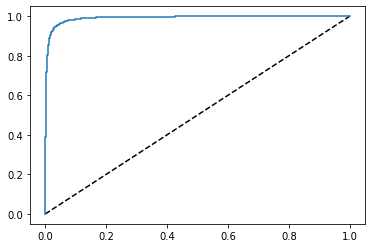

0.9912689289620104


In [24]:
fpr, tpr, _ = roc_curve(y, stepwise_model.predict(sm.add_constant(X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

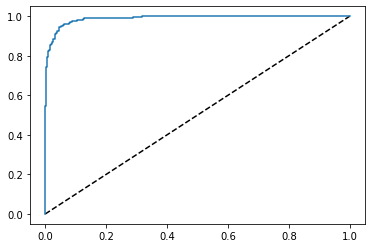

0.9887156874922369


In [25]:
fpr, tpr, _ = roc_curve(validate_y, stepwise_model.predict(sm.add_constant(validate_X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

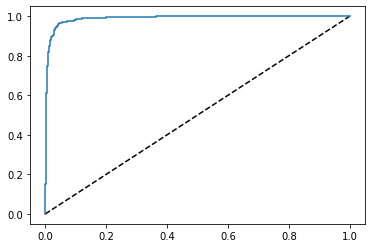

0.989259219460165


In [26]:
fpr, tpr, _ = roc_curve(test_y, stepwise_model.predict(sm.add_constant(test_X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

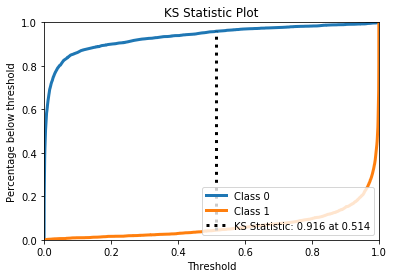

In [27]:
proba = [[1-x, x] for x in stepwise_model.predict(sm.add_constant(X[stepwise_features]))]

plot_ks_statistic(y, proba)
plt.show()

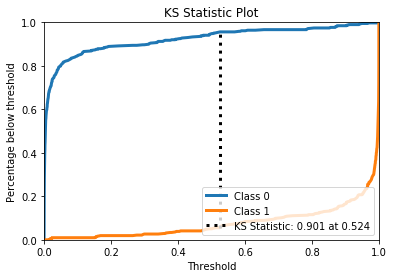

In [28]:
proba = [[1-x, x] for x in stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))]

plot_ks_statistic(validate_y, proba)
plt.show()

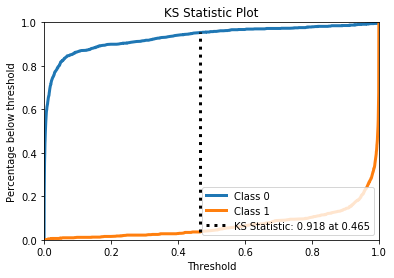

In [29]:
proba = [[1-x, x] for x in stepwise_model.predict(sm.add_constant(test_X[stepwise_features]))]

plot_ks_statistic(test_y, proba)
plt.show()

In [30]:
result = pd.DataFrame({'AUC': [roc_auc_score(y, stepwise_model.predict(sm.add_constant(X[stepwise_features]))),
                               roc_auc_score(validate_y, stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))),
                               roc_auc_score(test_y, stepwise_model.predict(sm.add_constant(test_X[stepwise_features])))],
                       'KS Statistic': [0.916, 0.901, 0.918],
                       'Accuracy': [accuracy_score(y, [1 if prob >= 0.514 else 0 for prob in stepwise_model.predict(sm.add_constant(X[stepwise_features]))]),
                                    accuracy_score(validate_y, [1 if prob >= 0.524 else 0 for prob in stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))]),
                                    accuracy_score(test_y, [1 if prob >= 0.465 else 0 for prob in stepwise_model.predict(sm.add_constant(test_X[stepwise_features]))])]})
result.index = ['Train', 'Validate', 'Test']
result

,AUC,KS Statistic,Accuracy
Train,0.991269,0.918,0.957473
Validate,0.988716,0.892,0.948941
Test,0.989259,0.916,0.957627


In [31]:
confusion_matrix(y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(X[stepwise_features]))])

array([[3437,  155],
       [ 152, 3475]], dtype=int64)

In [32]:
confusion_matrix(validate_y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))])

array([[368,  20],
       [ 21, 394]], dtype=int64)

In [33]:
confusion_matrix(test_y, [1 if prob >= 0.503 else 0 for prob in stepwise_model.predict(sm.add_constant(test_X[stepwise_features]))])

array([[990,  44],
       [ 41, 931]], dtype=int64)

# Model Evaluation

In [34]:
X = data.drop('Win', axis = 1)
y = data['Win']

In [35]:
stepwise_features = stepwise_regression(X, y)
stepwise_features

['Tower_Destroyed',
 'Total_Deaths',
 'Game_Duration',
 'Baron_Killed',
 'Total_Champion_Level',
 'Inhibitor_Destroyed',
 'Dragon_Killed',
 'Total_Magic_Damage_To_Champions',
 'Total_Neutral_Minions_Killed',
 'Total_Gold_Earned',
 'Total_Minions_Killed',
 'Total_Vision_Score',
 'Total_Physical_Damage_To_Champions',
 'Total_Neutral_Minions_Killed_Enemy_Jungle',
 'First_Tower',
 'Total_Time_CCing_Others',
 'Total_True_Damage_To_Champions',
 'Total_Physical_Damage_Taken',
 'Total_Magical_Damage_Taken',
 'Total_Heal']

In [36]:
model = sm.GLM(y, sm.add_constant(X[stepwise_features]), family = sm.families.Binomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                10028
Model:                            GLM   Df Residuals:                    10007
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1195.2
Date:                Thu, 25 Feb 2021   Deviance:                       2390.4
Time:                        03:36:52   Pearson chi2:                 2.51e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -1.0252      0.198     -5.166      0.000      -1.414      -0.636
Tower_Destroyed                               0.5426      0.043     12.481      0.000       0.457       0.628
Total_Deaths                                 -0.2508      0.011    -22.814      0.000      -0.272      -0.229
Game_Duration                                -0.0092      0.001    -17.943      0.000      -0.010      -0.008
Baron_Killed                                  0.3744      0.119      3.148      0.002       0.141       0.608
Total_Champion_Level                          0.1576      0.014     11.090      0.000       0.130       0.185
Inhibitor_Destroyed                           0.6810      0.086      7.898      0.000       0.512       0.850
Dragon_Killed                                 0.4051      0.059      6.878      0.000       0.290       0.521
Total_Magic_Damage_To_Champions            4.062e-05   4.86e-06      8.351      0.000    3.11e-05    5.02e-05
Total_Neutral_Minions_Killed                 -0.0095      0.002     -4.257      0.000      -0.014      -0.005
Total_Gold_Earned                             0.0003   2.47e-05     13.565      0.000       0.000       0.000
Total_Minions_Killed                         -0.0095      0.001     -9.277      0.000      -0.012      -0.007
Total_Vision_Score                           -0.0112      0.002     -4.726      0.000      -0.016      -0.007
Total_Physical_Damage_To_Champions         2.961e-05   5.51e-06      5.374      0.000    1.88e-05    4.04e-05
Total_Neutral_Minions_Killed_Enemy_Jungle    -0.0145      0.006     -2.504      0.012      -0.026      -0.003
First_Tower                                   0.3252      0.119      2.723      0.006       0.091       0.559
Total_Time_CCing_Others                      -0.0038      0.001     -2.840      0.005      -0.006      -0.001
Total_True_Damage_To_Champions             3.385e-05    1.4e-05      2.421      0.015    6.45e-06    6.13e-05
Total_Physical_Damage_Taken               -3.826e-05   5.52e-06     -6.927      0.000   -4.91e-05   -2.74e-05
Total_Magical_Damage_Taken                -3.054e-05    5.2e-06     -5.876      0.000   -4.07e-05   -2.04e-05
Total_Heal                                 2.391e-05   6.66e-06      3.590      0.000    1.09e-05     3.7e-05
=============================================================================================================
"""

In [37]:
critical_value = stats.chi2.ppf(0.95, df=model.df_resid)
p_value = stats.chi2.sf(model.deviance, df=model.df_resid)

print('Test statistic:', model.deviance)
print('Critical value:', critical_value)
print('p-value:', p_value)

Test statistic: 2390.4031810230717
Critical value: 10240.830301485796
p-value: 1.0


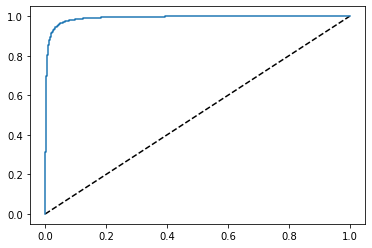

0.9908231821263446


In [38]:
fpr, tpr, _ = roc_curve(y, model.predict(sm.add_constant(X[stepwise_features])))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.show()
print(auc(fpr, tpr))

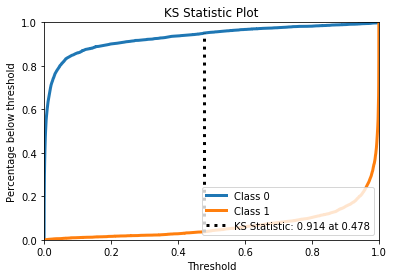

In [39]:
proba = [[1-x, x] for x in model.predict(sm.add_constant(X[stepwise_features]))]

plot_ks_statistic(y, proba)
plt.show()

In [40]:
accuracy_score(y, [1 if prob >= 0.478 else 0 for prob in model.predict(sm.add_constant(X[stepwise_features]))])

0.956122856003191

In [41]:
confusion_matrix(y, [1 if prob >= 0.478 else 0 for prob in model.predict(sm.add_constant(X[stepwise_features]))])

array([[4799,  215],
       [ 225, 4789]], dtype=int64)

In [42]:
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X[stepwise_features]).values, i) for i in range(X[stepwise_features].shape[1] + 1)]
vif['feature'] = sm.add_constant(X[stepwise_features]).columns
vif.drop(0).sort_values('vif', ascending = False).head(10)

,vif,feature
10,59.941510,Total_Gold_Earned
5,20.562489,Total_Champion_Level
3,18.694473,Game_Duration
18,11.377536,Total_Physical_Damage_Taken
11,7.754166,Total_Minions_Killed
1,7.443270,Tower_Destroyed
13,6.838603,Total_Physical_Damage_To_Champions
2,6.758852,Total_Deaths
19,6.060687,Total_Magical_Damage_Taken
9,5.659929,Total_Neutral_Minions_Killed


In [43]:
X[stepwise_features].corr()['Total_Gold_Earned'].abs().sort_values(ascending = False).head(10)
# Total_Gold_Earned is much correlated to other variables, e.g. Total_Champion_Level, Game_Duration

Total_Gold_Earned                     1.000000
Total_Champion_Level                  0.960307
Game_Duration                         0.933739
Total_Minions_Killed                  0.883357
Total_Physical_Damage_Taken           0.820507
Total_Physical_Damage_To_Champions    0.815863
Total_Vision_Score                    0.804874
Total_Heal                            0.804561
Total_Neutral_Minions_Killed          0.792801
Total_Magic_Damage_To_Champions       0.725980
Name: Total_Gold_Earned, dtype: float64

In [44]:
new_stepwise_features = stepwise_features.copy()
new_stepwise_features.remove('Total_Gold_Earned')

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X[new_stepwise_features]).values, i) for i in range(X[new_stepwise_features].shape[1] + 1)]
vif['feature'] = sm.add_constant(X[new_stepwise_features]).columns
vif.drop(0).sort_values('vif', ascending = False).head(10)

,vif,feature
3,18.132706,Game_Duration
5,16.086185,Total_Champion_Level
17,11.256119,Total_Physical_Damage_Taken
10,7.044496,Total_Minions_Killed
2,6.722010,Total_Deaths
1,6.141781,Tower_Destroyed
18,6.009963,Total_Magical_Damage_Taken
9,5.598978,Total_Neutral_Minions_Killed
19,4.864715,Total_Heal
12,4.720400,Total_Physical_Damage_To_Champions


In [45]:
reduced_model = sm.GLM(y, sm.add_constant(X[new_stepwise_features]), family = sm.families.Binomial()).fit()
reduced_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    Win   No. Observations:                10028
Model:                            GLM   Df Residuals:                    10008
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1298.3
Date:                Thu, 25 Feb 2021   Deviance:                       2596.6
Time:                        03:36:57   Pearson chi2:                 1.52e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        -1.3032      0.199     -6.565      0.000      -1.692      -0.914
Tower_Destroyed                               0.7617      0.040     19.067      0.000       0.683       0.840
Total_Deaths                                 -0.2341      0.011    -22.063      0.000      -0.255      -0.213
Game_Duration                                -0.0075      0.000    -16.436      0.000      -0.008      -0.007
Baron_Killed                                  0.8742      0.115      7.595      0.000       0.649       1.100
Total_Champion_Level                          0.2501      0.013     19.899      0.000       0.225       0.275
Inhibitor_Destroyed                           0.6173      0.084      7.380      0.000       0.453       0.781
Dragon_Killed                                 0.4368      0.056      7.758      0.000       0.326       0.547
Total_Magic_Damage_To_Champions            7.402e-05   4.37e-06     16.938      0.000    6.55e-05    8.26e-05
Total_Neutral_Minions_Killed                 -0.0063      0.002     -2.997      0.003      -0.010      -0.002
Total_Minions_Killed                         -0.0052      0.001     -5.568      0.000      -0.007      -0.003
Total_Vision_Score                           -0.0067      0.002     -2.963      0.003      -0.011      -0.002
Total_Physical_Damage_To_Champions         7.116e-05   4.73e-06     15.045      0.000    6.19e-05    8.04e-05
Total_Neutral_Minions_Killed_Enemy_Jungle    -0.0108      0.006     -1.957      0.050      -0.022    1.78e-05
First_Tower                                   0.2903      0.115      2.535      0.011       0.066       0.515
Total_Time_CCing_Others                      -0.0042      0.001     -3.188      0.001      -0.007      -0.002
Total_True_Damage_To_Champions              7.78e-05   1.39e-05      5.585      0.000    5.05e-05       0.000
Total_Physical_Damage_Taken               -2.967e-05   5.37e-06     -5.522      0.000   -4.02e-05   -1.91e-05
Total_Magical_Damage_Taken                -2.636e-05   5.11e-06     -5.160      0.000   -3.64e-05   -1.64e-05
Total_Heal                                 2.504e-05   6.66e-06      3.760      0.000     1.2e-05    3.81e-05
=============================================================================================================
"""

In [46]:
test_statistic = 2*(reduced_model.deviance - model.deviance)
critical_value = stats.chi2.ppf(0.95, df=1)
p_value = stats.chi2.sf(test_statistic, df=1)

print('Test statistic:', test_statistic)
print('Critical value:', critical_value)
print('p-value:', p_value)
# To reduce the significance of collinearity problem, the deviance increases signficantly. 
# Thus, we do not drop Total_Gold_Earned

Test statistic: 412.41762446377834
Critical value: 3.841458820694124
p-value: 1.0911273555704924e-91


# Conclusion

1. From the final model, we can see that 15 factors (e.g. Total Assist) are not significant to the win rate. For example, before the jungler of a team ganks a lane, the laner(s) of that team may start action first. Sometimes, the laner(s) may be able to kill the opposite laner(s) without the help of the jungler. In this case, the laner(s) may not need to wait for the jungler to come and participate if it makes the kill become more difficult.
2. From the final model, we can interpret how the significant factors affecting the odd ratio. Interestingly, for example, we have 95\% confidence that 10 second increase in time CCing others will be associated with from 1.98\% to 6.76\% decrease in the odd ratio. This suggest that when we are picking champions, we should less consider the champions with crowd control ability.

# Problems

1. There is a significant collinearity problem. We tried to drop the most correlated variable, Total money earned, but it makes the deviance increase a lot. The significant collinearity problem makes the standard error become too large.
2. In the game setting, some variables in nature affect each other. For example, getting the first tower will award extra money to the team. In this case, when interpreting the odd ratio, we need to consider the effect of the extra money as well.

# Further Work

1. The analysis needs to be frequently updated as the patch will frequently change. The factors affecting the win rate will also change.
2. The analysis focus on the team aspect. In the future, we can try to analyze the win rate in individual aspect.
3. The analysis is about unrank games. We can also try to analyze high elo games in the future.